生成分类样例数据：

In [1]:
from sklearn.datasets import make_classification

X, y = make_classification(n_features = 2, n_informative = 2, n_redundant = 0, n_samples = 100, n_classes = 2, random_state = 0)
y[y == 0] = -1

决策树学习算法实现（信息增益-Information Gain）：

In [2]:
import numpy as np

class GainNode:
    """
    分类决策树中的结点
    基于信息增益-Information Gain
    """
    
    def __init__(self, feature=None, threshold=None, gain=None, left=None, right=None):
        # 结点划分的特征下标
        self.feature = feature
        # 结点划分的临界值，当结点为叶子结点时为分类值
        self.threshold = threshold
        # 结点的信息增益值
        self.gain = gain
        # 左结点
        self.left = left
        # 右结点
        self.right = right

class GainTree:
    """
    分类决策树
    基于信息增益-Information Gain
    """
    
    def __init__(self, max_depth = None, min_samples_leaf = None):
        # 决策树最大深度
        self.max_depth = max_depth
        # 决策树叶结点最小样本数
        self.min_samples_leaf = min_samples_leaf
        
    def fit(self, X, y):
        """
        分类决策树拟合
        基于信息增益-Information Gain
        """
        y = np.array(y)
        self.root = self.buildNode(X, y, 0)
        return self
    
    def buildNode(self, X, y, depth):
        """
        构建分类决策树结点
        基于信息增益-Information Gain
        """
        node = GainNode()
        # 当没有样本时直接返回
        if len(y) == 0:
            return node
        y_classes = np.unique(y)
        # 当样本中只存在一种分类时直接返回该分类
        if len(y_classes) == 1:
            node.threshold = y_classes[0]
            return node
        # 当决策树深度达到最大深度限制时返回样本中分类占比最大的分类
        if self.max_depth is not None and depth >= self.max_depth:
            node.threshold = max(y_classes, key=y.tolist().count)
            return node
        # 当决策树叶结点样本数达到最小样本数限制时返回样本中分类占比最大的分类
        if self.min_samples_leaf is not None and len(y) <= self.min_samples_leaf:
            node.threshold = max(y_classes, key=y.tolist().count)
            return node
        max_gain = -np.inf
        max_middle = None
        max_feature = None
        # 遍历所有特征，获取信息增益最大的特征
        for i in range(X.shape[1]):
            # 计算特征的信息增益
            gain, middle = self.calcGain(X[:,i], y, y_classes)
            if max_gain < gain:
                max_gain = gain
                max_middle = middle
                max_feature = i
        # 信息增益最大的特征
        node.feature = max_feature
        # 临界值
        node.threshold = max_middle
        # 信息增益
        node.gain = max_gain
        X_lt = X[:,max_feature] < max_middle
        X_gt = X[:,max_feature] > max_middle
        # 递归处理左集合
        node.left = self.buildNode(X[X_lt,:], y[X_lt], depth + 1)
        # 递归处理右集合
        node.right = self.buildNode(X[X_gt,:], y[X_gt], depth + 1)
        return node
    
    def calcMiddle(self, x):
        """
        计算连续型特征的俩俩平均值
        """
        middle = []
        if len(x) == 0:
            return np.array(middle)
        start = x[0]
        for i in range(len(x) - 1):
            if x[i] == x[i + 1]:
                continue
            middle.append((start + x[i + 1]) / 2)
            start = x[i + 1]
        return np.array(middle)

    def calcEnt(self, y, y_classes):
        """
        计算信息熵
        """
        ent = 0
        for j in range(len(y_classes)):
            p = len(y[y == y_classes[j]])/ len(y)
            if p != 0:
                ent = ent + p * np.log2(p)
        return -ent

    def calcGain(self, x, y, y_classes):
        """
        计算信息增益
        """
        x_sort = np.sort(x)
        middle = self.calcMiddle(x_sort)
        max_middle = -np.inf
        max_gain = -np.inf
        ent = self.calcEnt(y, y_classes)
        # 遍历每个平均值
        for i in range(len(middle)):
            y_gt = y[x > middle[i]]
            y_lt = y[x < middle[i]]
            ent_gt = self.calcEnt(y_gt, y_classes)
            ent_lt = self.calcEnt(y_lt, y_classes)
            # 计算信息增益
            gain = ent - (ent_gt * len(y_gt) / len(x) + ent_lt * len(y_lt) / len(x))
            if max_gain < gain:
                max_gain = gain
                max_middle = middle[i]
        return max_gain, max_middle
    
    def predict(self, X):
        """
        分类决策树预测
        """
        y = np.zeros(X.shape[0])
        self.checkNode(X, y, self.root)
        return y
    
    def checkNode(self, X, y, node, cond = None):
        """
        通过分类决策树结点判断分类
        """
        # 当没有子结点时，直接返回当前临界值
        if node.left is None and node.right is None:
            return node.threshold
        X_lt = X[:,node.feature] < node.threshold
        if cond is not None:
            X_lt = X_lt & cond
        # 递归判断左结点
        lt = self.checkNode(X, y, node.left, X_lt)
        if lt is not None:
            y[X_lt] = lt
        X_gt = X[:,node.feature] > node.threshold
        if cond is not None:
            X_gt = X_gt & cond
        # 递归判断右结点
        gt = self.checkNode(X, y, node.right, X_gt)
        if gt is not None:
            y[X_gt] = gt

决策树学习算法拟合（信息增益-Information Gain）：

In [3]:
gainTree = GainTree(max_depth = 3, min_samples_leaf = 5)
gainTree.fit(X, y)

决策树分类可视化（信息增益-Information Gain）：

<IPython.core.display.Javascript object>


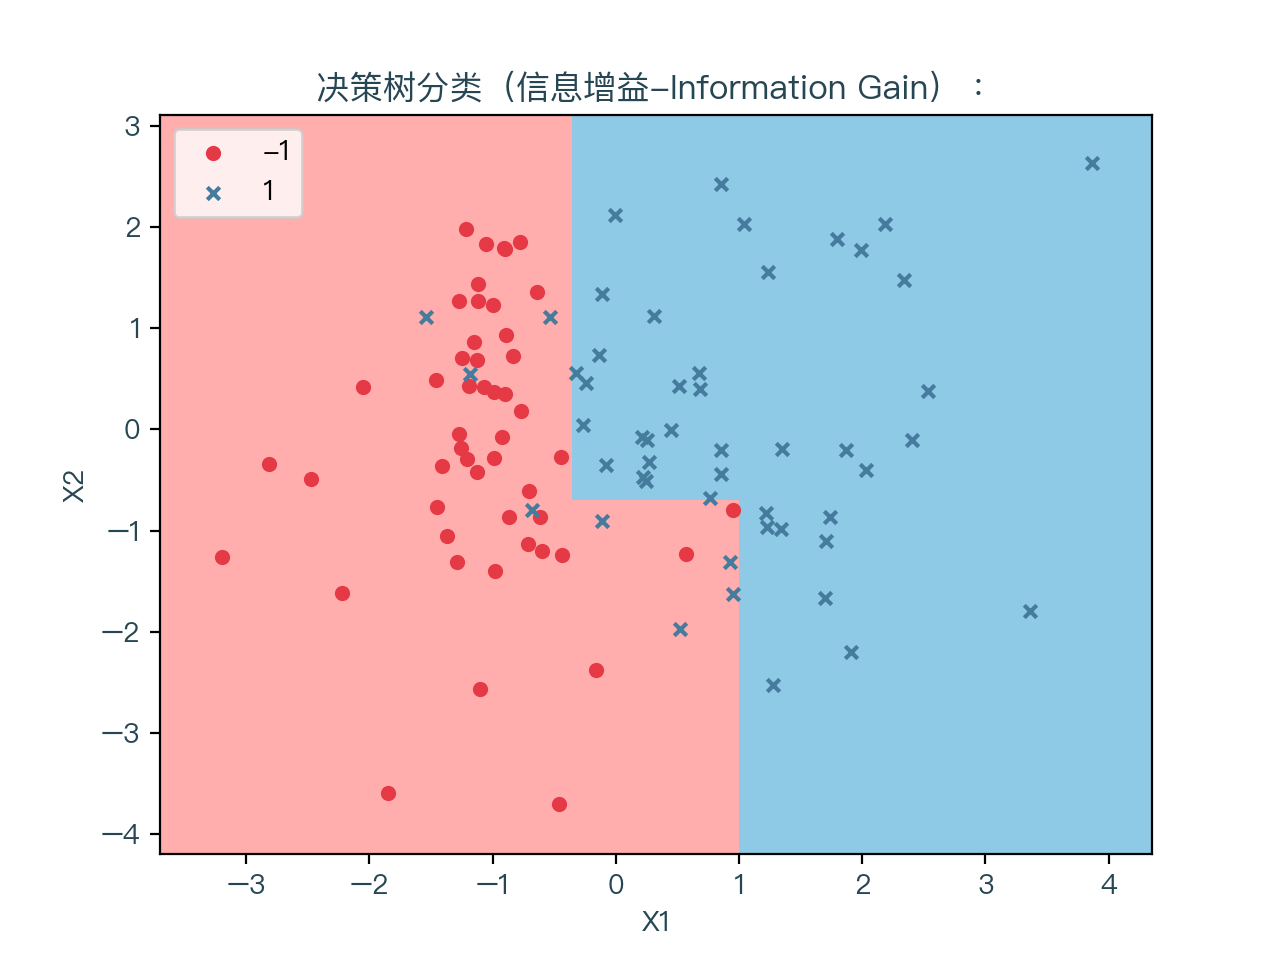

/Users/saisimon/opt/anaconda3/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

%matplotlib notebook

plt.rcParams['font.sans-serif'] = ['PingFang HK']  # 选择一个本地的支持中文的字体
fig, ax = plt.subplots()
ax.set_facecolor('#f8f9fa')

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, .05), np.arange(y_min, y_max, .05))
Z = gainTree.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
clist=['#ffadad', '#8ecae6']
newcmp = LinearSegmentedColormap.from_list('point_color', clist)
plt.pcolormesh(xx, yy, Z, cmap = newcmp)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

x1 = X[y==-1][:, 0]
y1 = X[y==-1][:, 1]
x2 = X[y==1][:, 0]
y2 = X[y==1][:, 1]
p1 = plt.scatter(x1, y1, c='#e63946', marker='o', s=20)
p2 = plt.scatter(x2, y2, c='#457b9d', marker='x', s=20)

ax.set_title('决策树分类（信息增益-Information Gain）：', color='#264653')
ax.set_xlabel('X1', color='#264653')
ax.set_ylabel('X2', color='#264653')
ax.tick_params(labelcolor='#264653')
plt.legend([p1, p2], ["-1", "1"], loc="upper left")
plt.show()

决策树分类（scikit-learn）：

In [5]:
from sklearn import tree

# 决策树分类
clf = tree.DecisionTreeClassifier(criterion = "entropy", max_depth = 3, min_samples_leaf = 5)
# 拟合数据
clf = clf.fit(X, y)

决策树分类可视化（scikit-learn）：

<IPython.core.display.Javascript object>


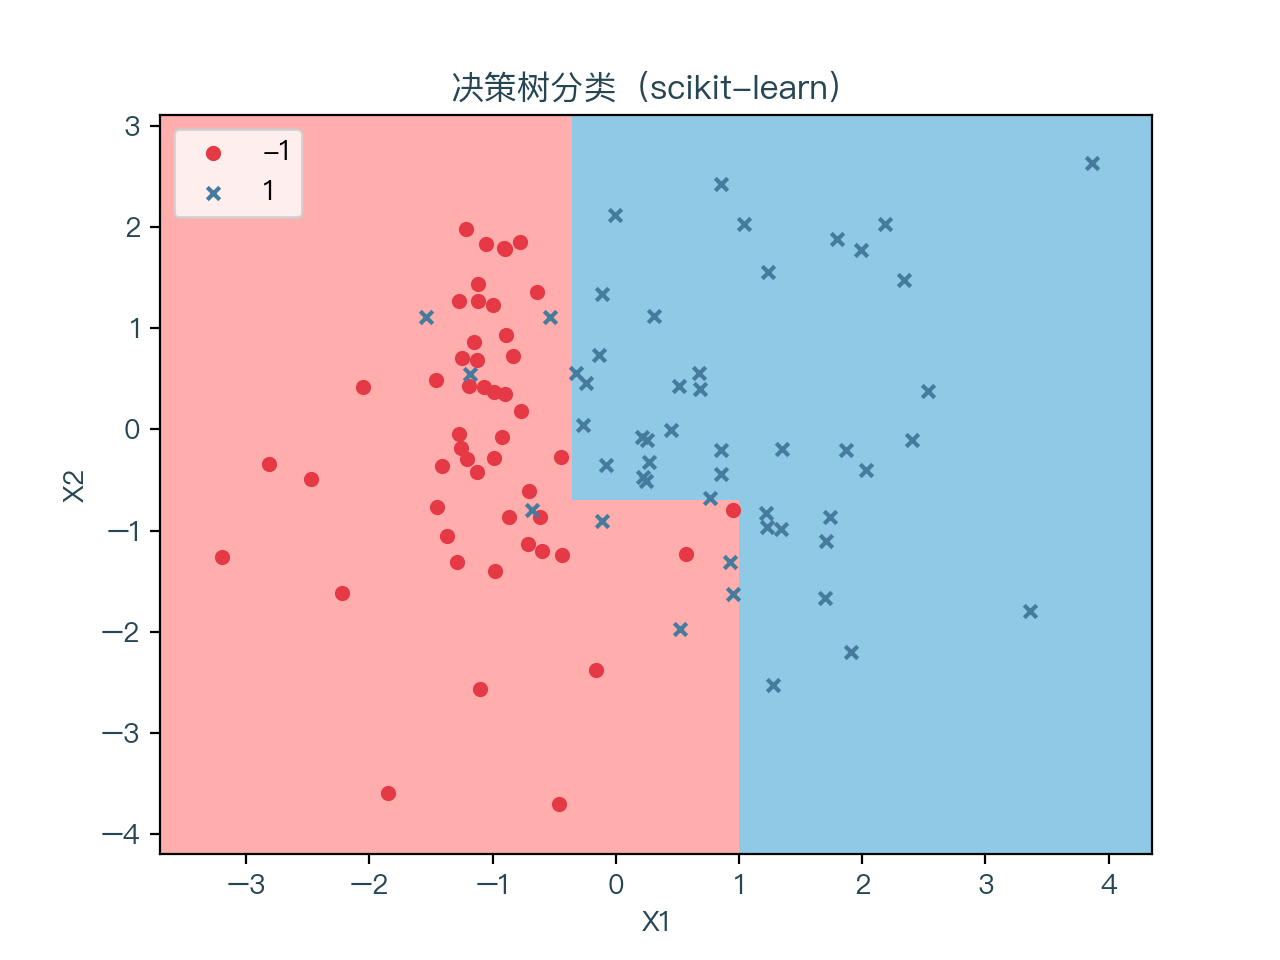

/Users/saisimon/opt/anaconda3/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

%matplotlib notebook

plt.rcParams['font.sans-serif'] = ['PingFang HK']  # 选择一个本地的支持中文的字体
fig, ax = plt.subplots()
ax.set_facecolor('#f8f9fa')

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, .05), np.arange(y_min, y_max, .05))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
clist=['#ffadad', '#8ecae6']
newcmp = LinearSegmentedColormap.from_list('point_color', clist)
plt.pcolormesh(xx, yy, Z, cmap = newcmp)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

x1 = X[y==-1][:, 0]
y1 = X[y==-1][:, 1]
x2 = X[y==1][:, 0]
y2 = X[y==1][:, 1]
p1 = plt.scatter(x1, y1, c='#e63946', marker='o', s=20)
p2 = plt.scatter(x2, y2, c='#457b9d', marker='x', s=20)

ax.set_title('决策树分类（scikit-learn）', color='#264653')
ax.set_xlabel('X1', color='#264653')
ax.set_ylabel('X2', color='#264653')
ax.tick_params(labelcolor='#264653')
plt.legend([p1, p2], ["-1", "1"], loc="upper left")
plt.show()

决策树分类实现（基尼指数-Gini Index）：

In [7]:
import numpy as np

class GiniNode:
    """
    分类决策树中的结点
    基于基尼指数-Gini Index
    """
    
    def __init__(self, feature=None, threshold=None, gini_index=None, left=None, right=None):
        # 结点划分的特征下标
        self.feature = feature
        # 结点划分的临界值，当结点为叶子结点时为分类值
        self.threshold = threshold
        # 结点的基尼指数值
        self.gini_index = gini_index
        # 左结点
        self.left = left
        # 右结点
        self.right = right

class GiniTree:
    """
    分类决策树
    基于基尼指数-Gini Index
    """
    
    def __init__(self, max_depth = None, min_samples_leaf = None):
        # 决策树最大深度
        self.max_depth = max_depth
        # 决策树叶结点最小样本数
        self.min_samples_leaf = min_samples_leaf
        
    def fit(self, X, y):
        """
        分类决策树拟合
        基于基尼指数-Gini Index
        """
        y = np.array(y)
        self.root = self.buildNode(X, y, 0)
        return self

    def buildNode(self, X, y, depth):
        """
        构建分类决策树结点
        基于基尼指数-Gini Index
        """
        node = GiniNode()
        # 当没有样本时直接返回
        if len(y) == 0:
            return node
        y_classes = np.unique(y)
        # 当样本中只存在一种分类时直接返回该分类
        if len(y_classes) == 1:
            node.threshold = y_classes[0]
            return node
        # 当决策树深度达到最大深度限制时返回样本中分类占比最大的分类
        if self.max_depth is not None and depth >= self.max_depth:
            node.threshold = max(y_classes, key=y.tolist().count)
            return node
        # 当决策树叶结点样本数达到最小样本数限制时返回样本中分类占比最大的分类
        if self.min_samples_leaf is not None and len(y) <= self.min_samples_leaf:
            node.threshold = max(y_classes, key=y.tolist().count)
            return node
        min_gini_index = np.inf
        min_middle = None
        min_feature = None
        # 遍历所有特征，获取基尼指数最小的特征
        for i in range(X.shape[1]):
            # 计算特征的基尼指数
            gini_index, middle = self.calcGiniIndex(X[:,i], y, y_classes)
            if min_gini_index > gini_index:
                min_gini_index = gini_index
                min_middle = middle
                min_feature = i
        # 基尼指数最小的特征
        node.feature = min_feature
        # 临界值
        node.threshold = min_middle
        # 基尼指数
        node.gini_index = min_gini_index
        X_lt = X[:,min_feature] < min_middle
        X_gt = X[:,min_feature] > min_middle
        # 递归处理左集合
        node.left = self.buildNode(X[X_lt,:], y[X_lt], depth + 1)
        # 递归处理右集合
        node.right = self.buildNode(X[X_gt,:], y[X_gt], depth + 1)
        return node
    
    def calcMiddle(self, x):
        """
        计算连续型特征的俩俩平均值
        """
        middle = []
        if len(x) == 0:
            return np.array(middle)
        start = x[0]
        for i in range(len(x) - 1):
            if x[i] == x[i + 1]:
                continue
            middle.append((start + x[i + 1]) / 2)
            start = x[i + 1]
        return np.array(middle)

    def calcGiniIndex(self, x, y, y_classes):
        """
        计算基尼指数
        """
        x_sort = np.sort(x)
        middle = self.calcMiddle(x_sort)
        min_middle = np.inf
        min_gini_index = np.inf
        for i in range(len(middle)):
            y_gt = y[x > middle[i]]
            y_lt = y[x < middle[i]]
            gini_gt = self.calcGini(y_gt, y_classes)
            gini_lt = self.calcGini(y_lt, y_classes)
            gini_index = gini_gt * len(y_gt) / len(x) + gini_lt * len(y_lt) / len(x)
            if min_gini_index > gini_index:
                min_gini_index = gini_index
                min_middle = middle[i]
        return min_gini_index, min_middle

    def calcGini(self, y, y_classes):
        """
        计算基尼值
        """
        gini = 1
        for j in range(len(y_classes)):
            p = len(y[y == y_classes[j]])/ len(y)
            gini = gini - p * p
        return gini
    
    def predict(self, X):
        """
        分类决策树预测
        """
        y = np.zeros(X.shape[0])
        self.checkNode(X, y, self.root)
        return y
    
    def checkNode(self, X, y, node, cond = None):
        """
        通过分类决策树结点判断分类
        """
        if node.left is None and node.right is None:
            return node.threshold
        X_lt = X[:,node.feature] < node.threshold
        if cond is not None:
            X_lt = X_lt & cond
        lt = self.checkNode(X, y, node.left, X_lt)
        if lt is not None:
            y[X_lt] = lt
        X_gt = X[:,node.feature] > node.threshold
        if cond is not None:
            X_gt = X_gt & cond
        gt = self.checkNode(X, y, node.right, X_gt)
        if gt is not None:
            y[X_gt] = gt

决策树分类拟合（基尼指数-Gini Index）：

In [8]:
giniTree = GiniTree(max_depth = 3, min_samples_leaf = 5)
giniTree.fit(X, y)

决策树分类可视化（基尼指数-Gini Index）：

<IPython.core.display.Javascript object>


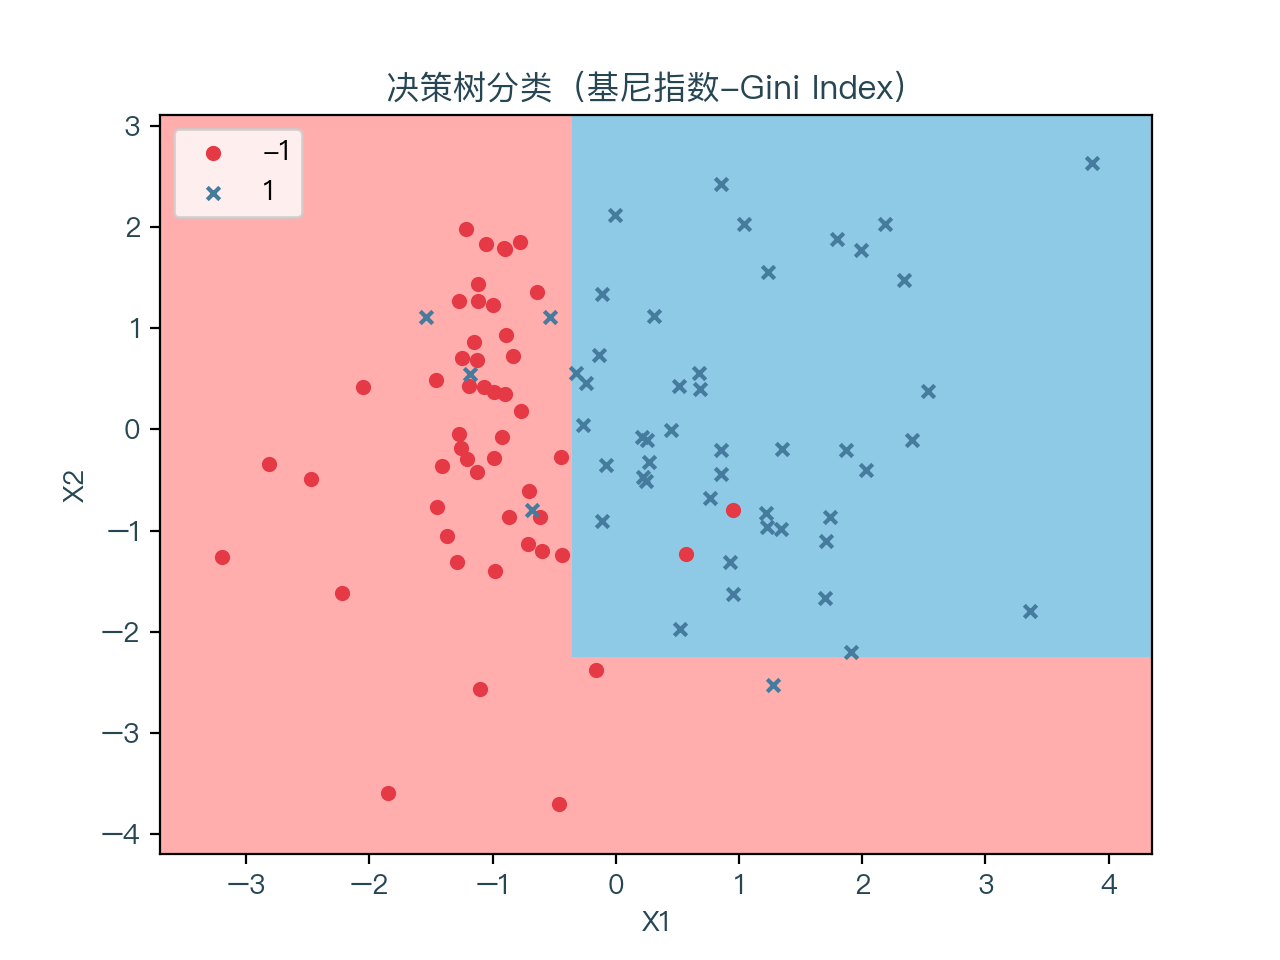

/Users/saisimon/opt/anaconda3/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

%matplotlib notebook

plt.rcParams['font.sans-serif'] = ['PingFang HK']  # 选择一个本地的支持中文的字体
fig, ax = plt.subplots()
ax.set_facecolor('#f8f9fa')

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, .05), np.arange(y_min, y_max, .05))
Z = giniTree.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
clist=['#ffadad', '#8ecae6']
newcmp = LinearSegmentedColormap.from_list('point_color', clist)
plt.pcolormesh(xx, yy, Z, cmap = newcmp)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

x1 = X[y==-1][:, 0]
y1 = X[y==-1][:, 1]
x2 = X[y==1][:, 0]
y2 = X[y==1][:, 1]
p1 = plt.scatter(x1, y1, c='#e63946', marker='o', s=20)
p2 = plt.scatter(x2, y2, c='#457b9d', marker='x', s=20)

ax.set_title('决策树分类（基尼指数-Gini Index）', color='#264653')
ax.set_xlabel('X1', color='#264653')
ax.set_ylabel('X2', color='#264653')
ax.tick_params(labelcolor='#264653')
plt.legend([p1, p2], ["-1", "1"], loc="upper left")
plt.show()

决策树分类（scikit-learn）：

In [10]:
from sklearn import tree

clf = tree.DecisionTreeClassifier(criterion = "gini", max_depth = 3, min_samples_leaf = 5)
clf = clf.fit(X, y)

决策树分类可视化（scikit-learn）：

<IPython.core.display.Javascript object>


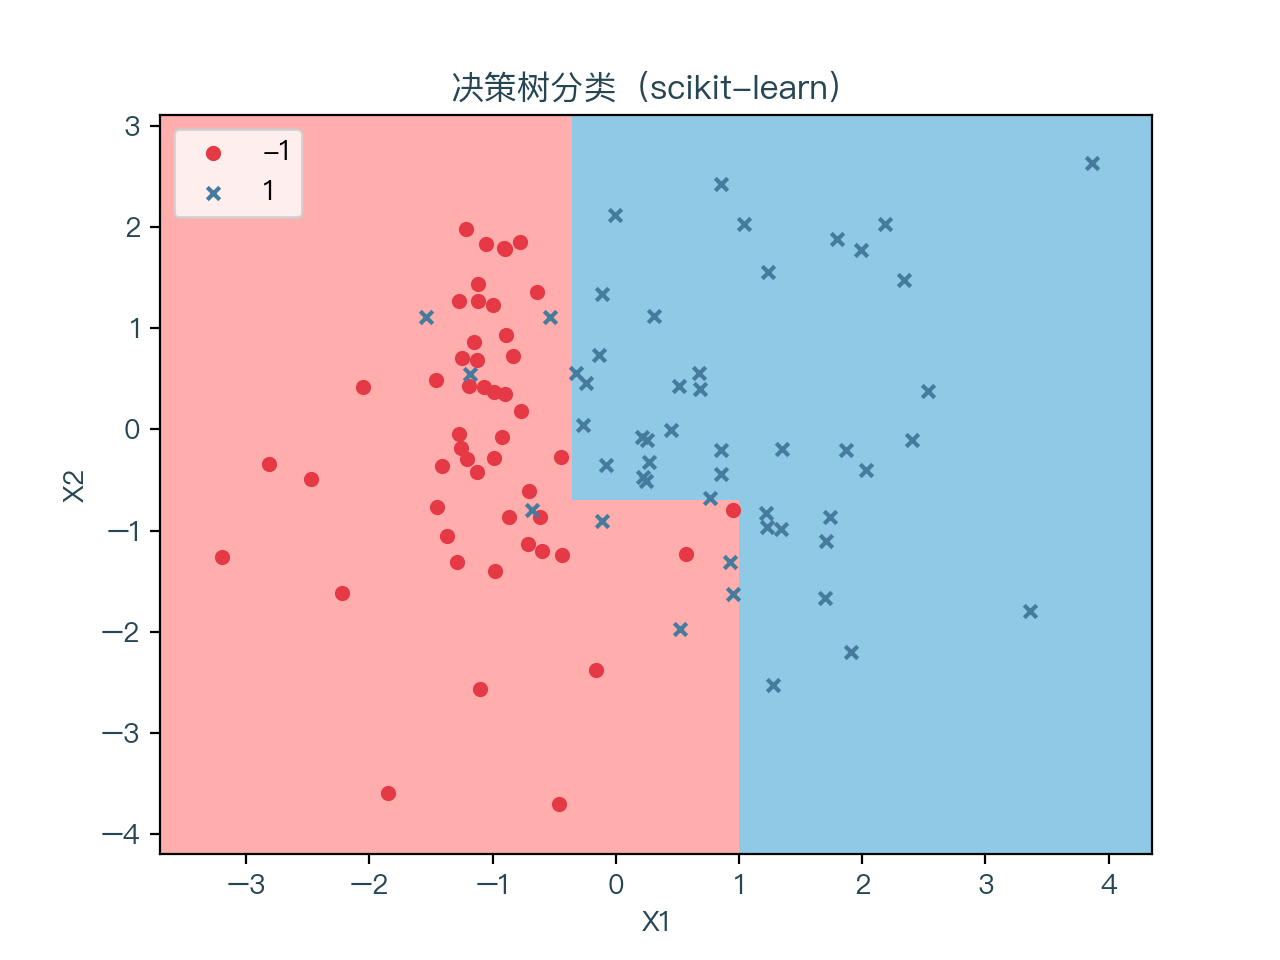

/Users/saisimon/opt/anaconda3/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

%matplotlib notebook

plt.rcParams['font.sans-serif'] = ['PingFang HK']  # 选择一个本地的支持中文的字体
fig, ax = plt.subplots()
ax.set_facecolor('#f8f9fa')

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, .05), np.arange(y_min, y_max, .05))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
clist=['#ffadad', '#8ecae6']
newcmp = LinearSegmentedColormap.from_list('point_color', clist)
plt.pcolormesh(xx, yy, Z, cmap = newcmp)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

x1 = X[y==-1][:, 0]
y1 = X[y==-1][:, 1]
x2 = X[y==1][:, 0]
y2 = X[y==1][:, 1]
p1 = plt.scatter(x1, y1, c='#e63946', marker='o', s=20)
p2 = plt.scatter(x2, y2, c='#457b9d', marker='x', s=20)

ax.set_title('决策树分类（scikit-learn）', color='#264653')
ax.set_xlabel('X1', color='#264653')
ax.set_ylabel('X2', color='#264653')
ax.tick_params(labelcolor='#264653')
plt.legend([p1, p2], ["-1", "1"], loc="upper left")
plt.show()

生成回归样例数据：

In [12]:
from sklearn.datasets import make_regression

X, y = make_regression(n_features = 1, n_targets = 1, n_samples = 100, noise=5, random_state = 0)

决策树回归实现（均方差-MSE）：

In [13]:
import numpy as np

class RegressorNode:
    """
    回归决策树中的结点
    """
    
    def __init__(self, feature=None, threshold=None, mse=None, left=None, right=None):
        # 结点划分的特征下标
        self.feature = feature
        # 结点划分的临界值，当结点为叶子结点时为分类值
        self.threshold = threshold
        # 结点的均方差值
        self.mse = mse
        # 左结点
        self.left = left
        # 右结点
        self.right = right

class RegressorTree:
    """
    回归决策树
    """
    
    def __init__(self, max_depth = None, min_samples_leaf = None):
        # 决策树最大深度
        self.max_depth = max_depth
        # 决策树叶结点最小样本数
        self.min_samples_leaf = min_samples_leaf
        
    def fit(self, X, y):
        """
        回归决策树拟合
        """
        self.root = self.buildNode(X, y, 0)
        return self

    def buildNode(self, X, y, depth):
        """
        构建回归决策树结点
        """
        node = RegressorNode()
        # 当没有样本时直接返回
        if len(y) == 0:
            return node
        y_classes = np.unique(y)
        # 当样本中只存在一种分类时直接返回该分类
        if len(y_classes) == 1:
            node.threshold = y_classes[0]
            return node
        # 当决策树深度达到最大深度限制时返回样本中分类占比最大的分类
        if self.max_depth is not None and depth >= self.max_depth:
            node.threshold = np.average(y)
            return node
        # 当决策树叶结点样本数达到最小样本数限制时返回样本中分类占比最大的分类
        if self.min_samples_leaf is not None and len(y) <= self.min_samples_leaf:
            node.threshold = np.average(y)
            return node
        min_mse = np.inf
        min_middle = None
        min_feature = None
        # 遍历所有特征，获取均方差最小的特征
        for i in range(X.shape[1]):
            # 计算特征的均方差
            mse, middle = self.calcMse(X[:,i], y)
            if min_mse > mse:
                min_mse = mse
                min_middle = middle
                min_feature = i
        # 均方差最小的特征
        node.feature = min_feature
        # 临界值
        node.threshold = min_middle
        # 均方差
        node.mse = min_mse
        X_lt = X[:,min_feature] < min_middle
        X_gt = X[:,min_feature] > min_middle
        # 递归处理左集合
        node.left = self.buildNode(X[X_lt,:], y[X_lt], depth + 1)
        # 递归处理右集合
        node.right = self.buildNode(X[X_gt,:], y[X_gt], depth + 1)
        return node
    
    def calcMiddle(self, x):
        """
        计算连续型特征的俩俩平均值
        """
        middle = []
        if len(x) == 0:
            return np.array(middle)
        start = x[0]
        for i in range(len(x) - 1):
            if x[i] == x[i + 1]:
                continue
            middle.append((start + x[i + 1]) / 2)
            start = x[i + 1]
        return np.array(middle)

    def calcMse(self, x, y):
        """
        计算均方差
        """
        x_sort = np.sort(x)
        middle = self.calcMiddle(x_sort)
        min_middle = np.inf
        min_mse = np.inf
        for i in range(len(middle)):
            y_gt = y[x > middle[i]]
            y_lt = y[x < middle[i]]
            avg_gt = np.average(y_gt)
            avg_lt = np.average(y_lt)
            mse = np.sum((y_lt - avg_lt) ** 2) + np.sum((y_gt - avg_gt) ** 2)
            if min_mse > mse:
                min_mse = mse
                min_middle = middle[i]
        return min_mse, min_middle
    
    def predict(self, X):
        """
        回归决策树预测
        """
        y = np.zeros(X.shape[0])
        self.checkNode(X, y, self.root)
        return y
    
    def checkNode(self, X, y, node, cond = None):
        """
        通过回归决策树结点判断分类
        """
        if node.left is None and node.right is None:
            return node.threshold
        X_lt = X[:,node.feature] < node.threshold
        if cond is not None:
            X_lt = X_lt & cond
        lt = self.checkNode(X, y, node.left, X_lt)
        if lt is not None:
            y[X_lt] = lt
        X_gt = X[:,node.feature] > node.threshold
        if cond is not None:
            X_gt = X_gt & cond
        gt = self.checkNode(X, y, node.right, X_gt)
        if gt is not None:
            y[X_gt] = gt

决策树回归拟合（均方差-MSE）：

In [14]:
regressorTree = RegressorTree(max_depth = 3, min_samples_leaf = 5)
regressorTree.fit(X, y)

决策树回归可视化（均方差-MSE）：

<IPython.core.display.Javascript object>


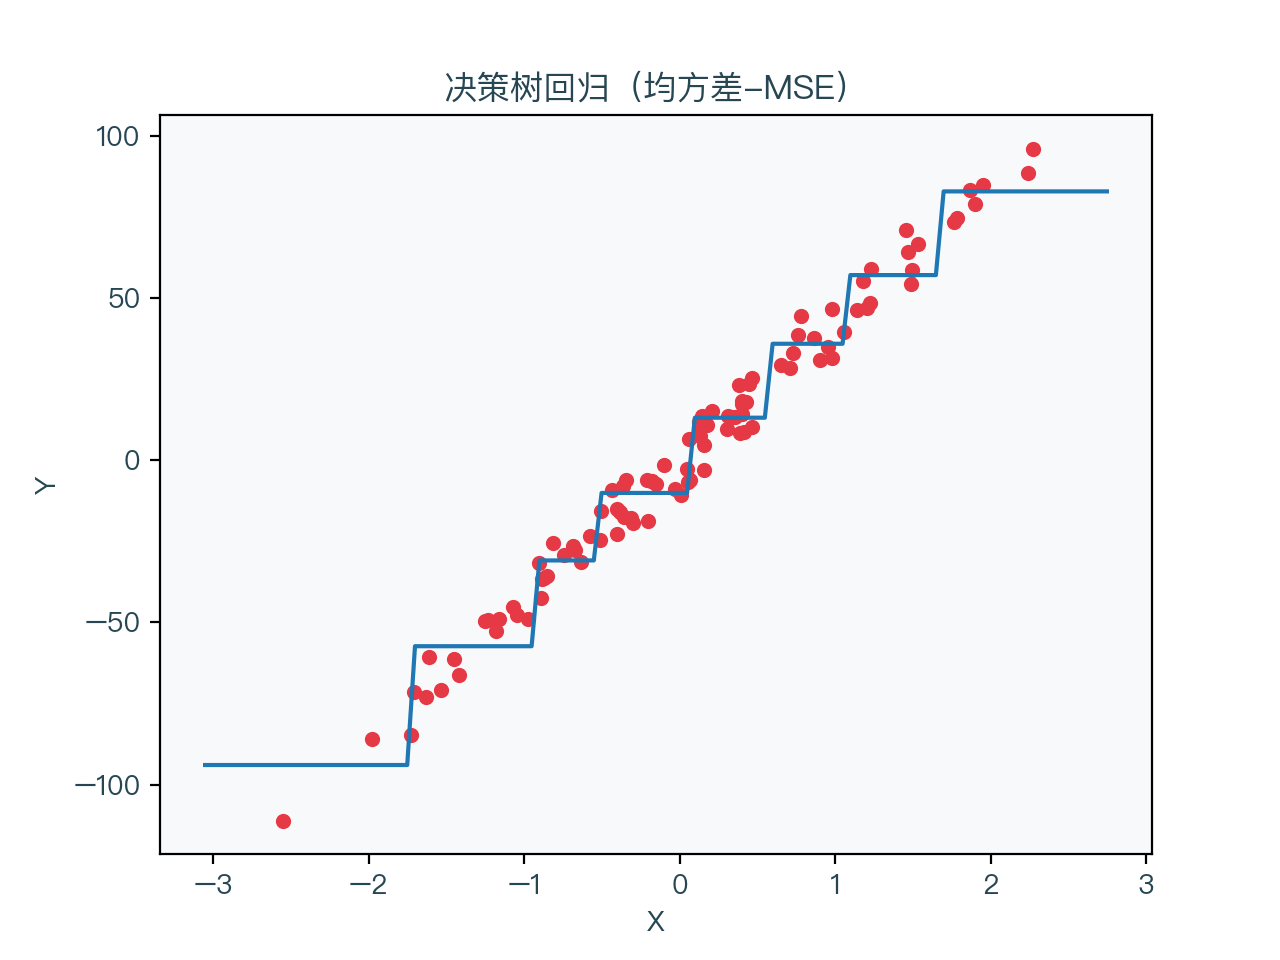

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

%matplotlib notebook

plt.rcParams['font.sans-serif'] = ['PingFang HK']  # 选择一个本地的支持中文的字体
fig, ax = plt.subplots()
ax.set_facecolor('#f8f9fa')

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
xx = np.arange(x_min, x_max, .05)
yy = regressorTree.predict(np.c_[xx.ravel()])

plt.scatter(X, y, c='#e63946', marker='o', s=20)
plt.plot(xx, yy)

ax.set_title('决策树回归（均方差-MSE）', color='#264653')
ax.set_xlabel('X', color='#264653')
ax.set_ylabel('Y', color='#264653')
ax.tick_params(labelcolor='#264653')
plt.show()

决策树回归（scikit-learn）：

In [16]:
from sklearn import tree

# 决策树回归
clf = tree.DecisionTreeRegressor(max_depth = 3, min_samples_leaf = 5)
# 拟合数据
clf = clf.fit(X, y)

决策树回归可视化（scikit-learn）：

<IPython.core.display.Javascript object>


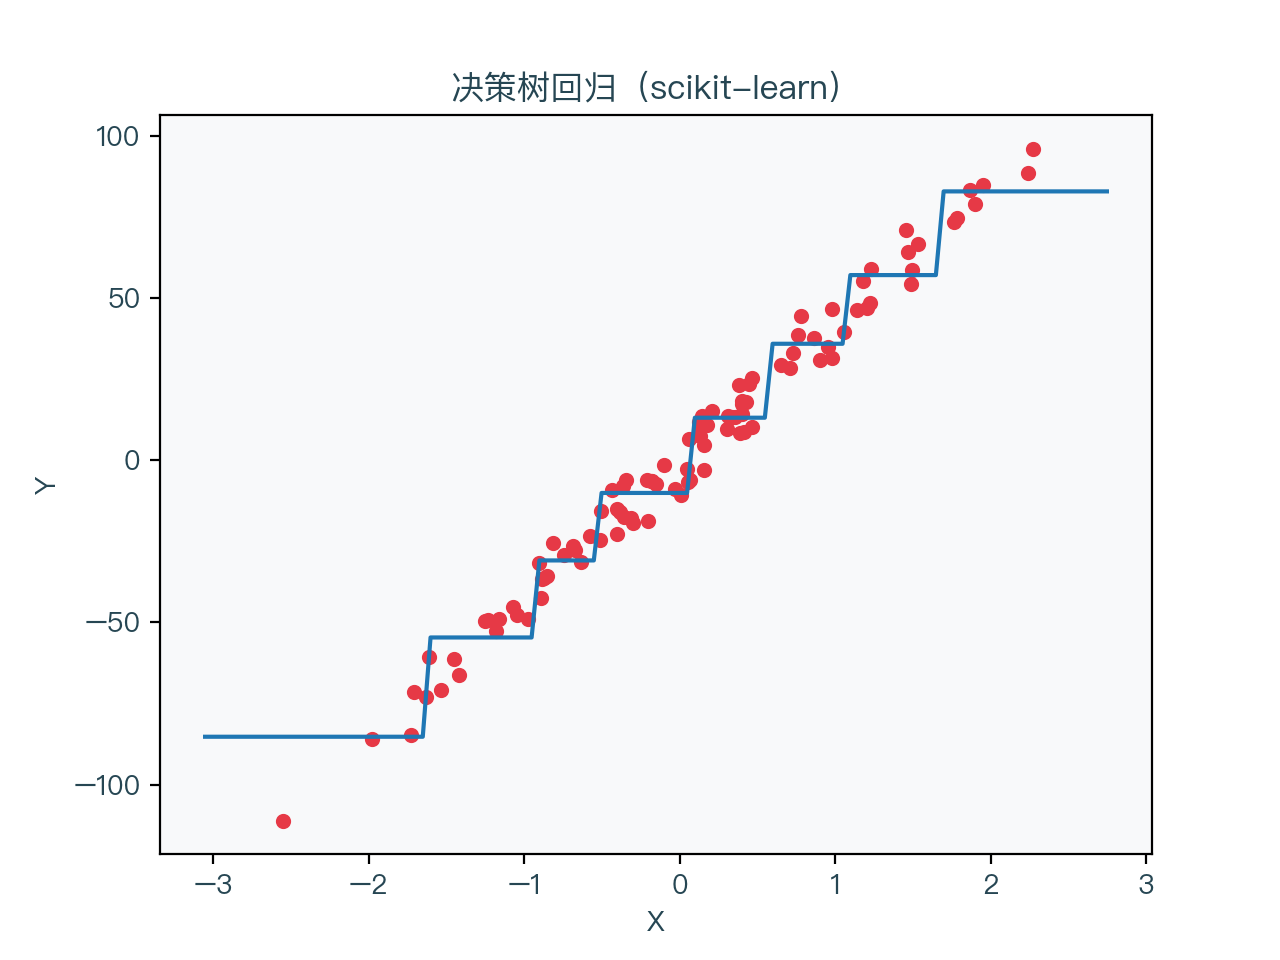

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

%matplotlib notebook

plt.rcParams['font.sans-serif'] = ['PingFang HK']  # 选择一个本地的支持中文的字体
fig, ax = plt.subplots()
ax.set_facecolor('#f8f9fa')

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
xx = np.arange(x_min, x_max, .05)
yy = clf.predict(np.c_[xx.ravel()])

plt.scatter(X, y, c='#e63946', marker='o', s=20)
plt.plot(xx, yy)

ax.set_title('决策树回归（scikit-learn）', color='#264653')
ax.set_xlabel('X', color='#264653')
ax.set_ylabel('Y', color='#264653')
ax.tick_params(labelcolor='#264653')
plt.show()